# Measure the radial velocity
This notebook uses the RVFitter class to do an MCMC fit. It looks up the spectral type on Simbad to estimate the temperature, and estimates the log(g) from the spectrum (you should have a Balmer line in there somewhere).

In [1]:
# Import a bunch of stuff
import StarData
import HelperFunctions
import Fitters
import Mamajek_Table
import SpectralTypeRelations
import matplotlib.pyplot as plt
import logging
import triangle
from astropy.io import fits
import numpy as np
import sys
import os

%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Get the HDF5 filename. Might want to change this eventually.
#home = os.environ['HOME']
#sys.path.append('{}/School/Research/CHIRON_data/Chiron-Scripts/'.format(home))
#from Search_slow import hdf5_filename
#hdf5_filename = '/Volumes/DATADRIVE/Kurucz_Grid/TS23_grid_full.hdf5'
hdf5_filename = '/media/ExtraSpace/Kurucz_FullGrid/IGRINS_grid.hdf5'

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<IPython.core.display.Javascript object>


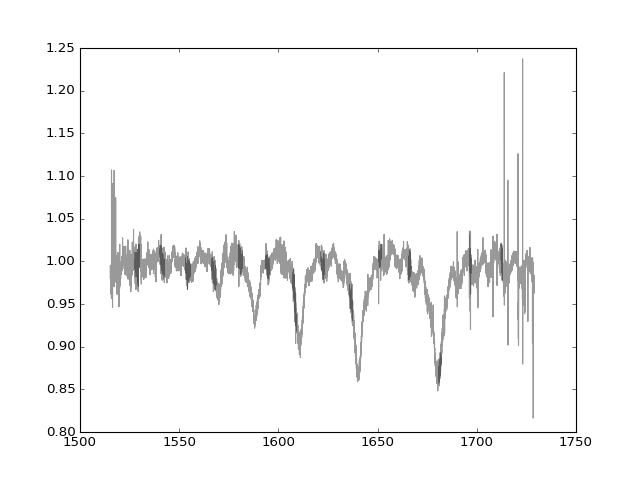

In [2]:
flattened_orders = HelperFunctions.ReadExtensionFits('../20140708/HIP_5131_telluric_corrected_renormalized.fits')
%matplotlib notebook
for order in flattened_orders:
    plt.plot(order.x, order.y, 'k-', alpha=0.4)

In [7]:
# Fit the RV to the flattened spectrum
teff, logg = 13193.3528155,4.5
reload(Fitters)
flat_fitter = Fitters.RVFitter(flattened_orders, model_library=hdf5_filename, 
                               T=teff, logg=logg, feh=0.0)
#flat_fitter.fit(backend='multinest', n_live_points=1000, basename='RVFitter/HIP109521_20131021-', overwrite=False)

Determine Chunk Log: Wl is 65536


In [8]:
flat_fitter.fit(backend='multinest', n_live_points=1000, basename='RVFitter/HIP5131_20140708-', overwrite=True)

/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (6983.28018188). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (104143.619537). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (97289.0853882). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (70972.442627). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (22027.4925232). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (55630.2070618). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1

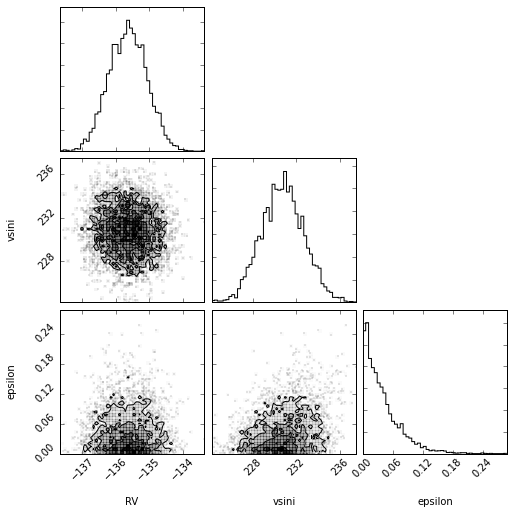

In [9]:
%matplotlib inline
flat_fitter.triangle()

In [10]:
flat_fitter.samples.describe()

,RV,epsilon,lnprob,vsini
count,4795.000000,4.795000e+03,4795.000000,4795.000000
mean,-135.640062,3.917289e-02,21535.574407,230.741966
std,0.565635,3.579007e-02,1.352341,1.959899
min,-137.659650,5.435070e-07,21527.450640,224.232313
25%,-136.035867,1.188779e-02,21534.885105,229.412000
50%,-135.634937,2.919752e-02,21535.874501,230.735853
75%,-135.246018,5.503572e-02,21536.579517,232.074100
max,-133.348981,2.880231e-01,21537.563181,237.415526


<IPython.core.display.Javascript object>


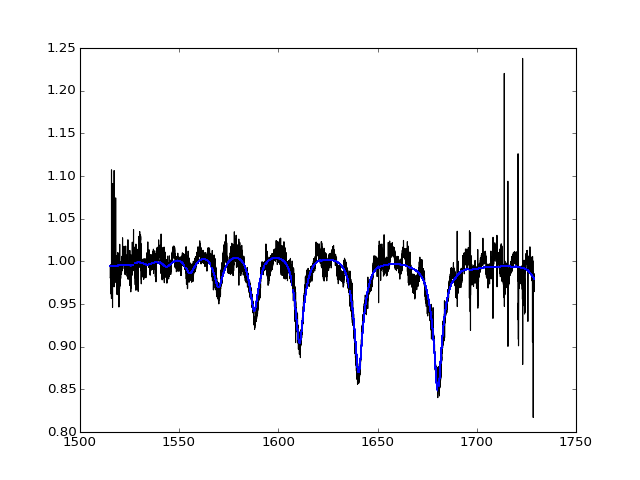

In [11]:
%matplotlib notebook
flat_fitter.plot()

# Try something else
IGRINS data only has the broad Hydrogen lines to go off of, and has lots of systematics/noise. So, let's try to just measure the effective wavelength of each line and get a mean velocity from the ~3-4 lines.

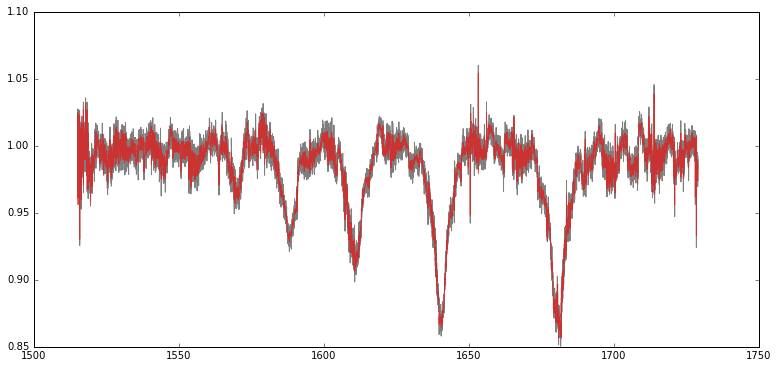

In [10]:
fname = '../20141015/HIP_109056_telluric_corrected_renormalized.fits'
orders = HelperFunctions.ReadExtensionFits(fname)
total = HelperFunctions.CombineXYpoints(orders)
denoised = HelperFunctions.Denoise(total.copy())

fig, ax = plt.subplots(1, 1, figsize=(13,6))
ax.plot(total.x, total.y, 'k-', alpha=0.5)
ax.plot(denoised.x, denoised.y, 'r-', alpha=0.6)

## Fringing. Check the FFT

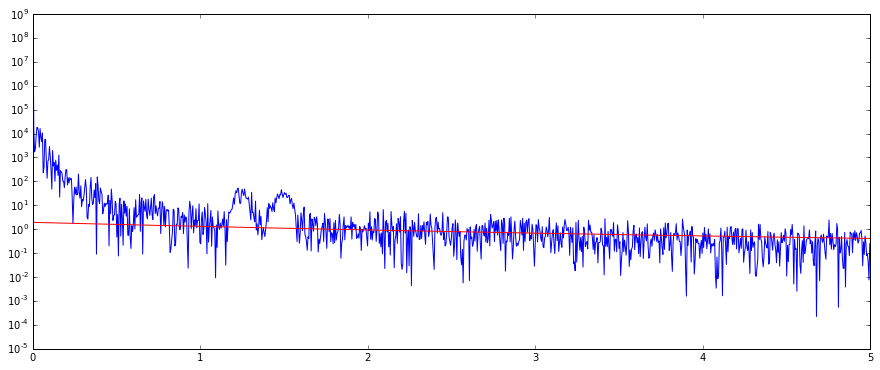

In [11]:
fft = np.fft.rfft(denoised.y)
freq = np.fft.rfftfreq(denoised.size(), d=denoised.x[1] - denoised.x[0])

fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.semilogy(freq, fft.imag**2 + fft.real**2)
ax.set_xlim((0, 5))

good = freq > 0.5
pars = np.polyfit(freq[good], np.log10(fft[good]), 4)
fit = np.poly1d(pars)
fft_fit = 10**fit(freq)
plt.plot(freq, fft_fit.imag**2 + fft_fit.real**2, 'r-')

There is definitely something there visible in the FFTs. I will fit the fft, and replace all values with frequencies between 1 and 2 cycles/nm to the fitted value. 

(0.85, 0.99)

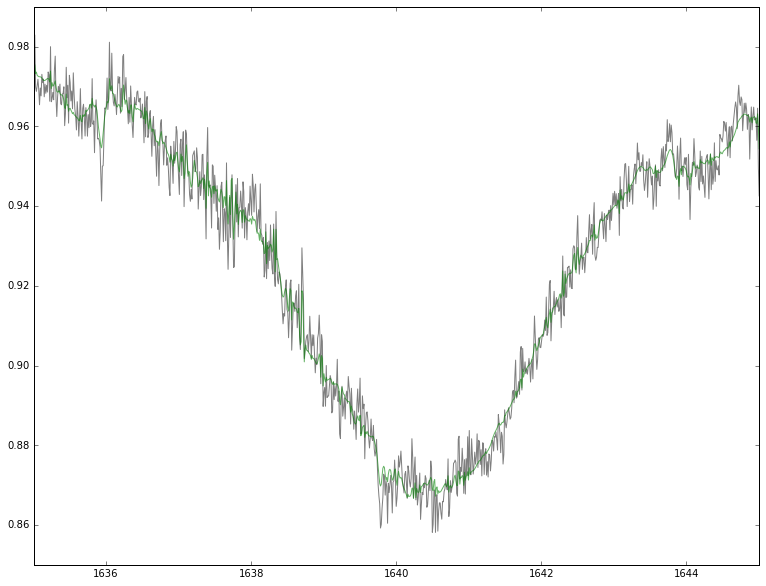

In [12]:
good = (freq > 1) & (freq < 2)
fft[good] = fft_fit[good]
spec = np.fft.irfft(fft)
defringed = total.copy()
defringed.y = spec


fig, ax = plt.subplots(1, 1, figsize=(13,10))
ax.plot(total.x, total.y, 'k-', alpha=0.5)
#ax.plot(denoised.x, denoised.y, 'r-', alpha=0.6)
ax.plot(defringed.x, defringed.y, 'g-', alpha=0.6)
ax.set_xlim((1635, 1645))
ax.set_ylim((0.85, 0.99))

# Compare line locations to what they should be

In [13]:
from astropy import units as u, constants
Ryd = 10967758.306 / u.m  # From Allen's Astrophysical Quantities
n_f = 4.0
n_i = np.arange(11, 16, 1, dtype=np.float)
true_waves = ((Ryd * (1./n_f**2 - 1./n_i**2))**(-1)).to(u.nm)

# Correct for index of refraction of air (use IAU standard conversion from
#  Morton, D. C. 1991, ApJS, 77, 119
wave_A = true_waves.to(u.angstrom).value  # Wavelength in angstroms
n = 1.0 + 2.735182e-4 + 131.4182 / wave_A ** 2 + 2.76249e8 / wave_A ** 4
true_waves /= n
print(true_waves)

[ 1680.6574612   1640.72444618  1610.93639085  1588.05916397  1570.07116873] nm


In [14]:
def get_centroid(xypt):
    weights = 1.0 - xypt.y
    centroid = np.sum(xypt.x*weights) / np.sum(weights)
    return centroid

def get_min_quadratic(xypt):
    pars = np.polyfit(xypt.x, xypt.y, 2)
    return -pars[1] / (2.0*pars[0])

def get_min_gaussian(xypt):
    #from fitters.linear import fit_gauss
    gauss = fit_gauss(xypt.x, 1.0 - xypt.y, add_linear=False)
    return gauss.parameters[-2]

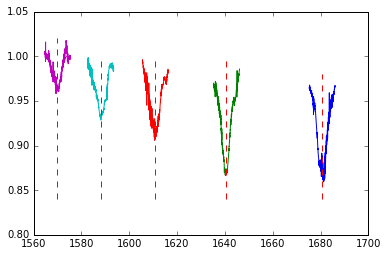

In [16]:
obs_waves = np.empty_like(true_waves)
N=500
for i, true_wave in enumerate(true_waves):
    idx = np.searchsorted(total.x, true_wave)
    segment = defringed[idx-N:idx+N]
    centroid = get_centroid(segment)
    #centroid = get_min_quadratic(segment)
    #centroid = get_min_gaussian(segment)
    obs_waves[i] = centroid*u.nm
    plt.plot(segment.x, segment.y)
    plt.plot((centroid, centroid), plt.ylim(), 'r--')

In [17]:
v = (obs_waves - true_waves) / true_waves * constants.c.to(u.km/u.s)
print(v)
print(np.mean(v), np.std(v))

[ 10.34261027 -38.11688772  -0.18269962  -0.72656834 -71.20437123] km / s
(<Quantity -19.977583329624476 km / s>, <Quantity 30.446580438283625 km / s>)


# Try cross-correlating the whole spectrum at once.

In [18]:
import StellarModel
reload(StellarModel)
HDF5_FILENAME = '/media/ExtraSpace/Kurucz_FullGrid/IGRINS_grid_air.hdf5'
model_list = StellarModel.GetModelList(metal=0.0, logg=4.0, temperature=9250, 
                                       type='hdf5', hdf5_file=HDF5_FILENAME)
modeldict, _ = StellarModel.MakeModelDicts(model_list, type='hdf5', hdf5_file=HDF5_FILENAME,
                                        vsini_values=150, vac2air=True, logspace=True)
model = modeldict[9250][4.0][0.0][0.0][150]

In [19]:
import Correlate
ccf = Correlate.GetCCF([defringed], model, vsini=150, resolution=45000, addmode='ml')

(-14.195579765376129, 1.5877212051765719, array(0.9264021085287532))

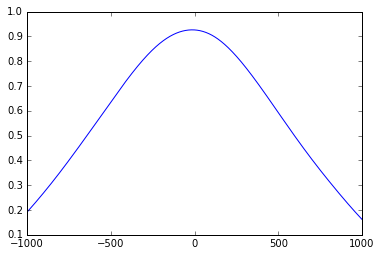

In [20]:
corr = ccf['CCF']
plt.plot(corr.x, corr.y)
Correlate.get_rv(corr.x, corr.y, Npix=defringed.size())

17.562445444


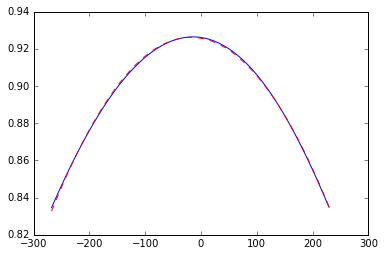

In [26]:
good = (corr.y > 0.9*corr.y.max())
plt.plot(corr.x[good], corr.y[good])
pars = np.polyfit(corr.x[good], corr.y[good], 2)
plt.plot(corr.x[good], np.poly1d(pars)(corr.x[good]), 'r--')
centroid = pars[1] / (2.0*pars[0])
print(centroid)

# That's closer. Lets make it a function and try in a few other stars.

In [80]:
def defringe_data(xypt):
    fft = np.fft.rfft(xypt.y)
    freq = np.fft.rfftfreq(xypt.size(), d=xypt.x[1] - xypt.x[0])

    good = freq > 0.5
    pars = np.polyfit(freq[good], np.log10(fft[good]), 4)
    fit = np.poly1d(pars)
    fft_fit = 10**fit(freq)
    
    good = (freq > 1) & (freq < 2)
    fft[good] = fft_fit[good]
    spec = np.fft.irfft(fft)
    defringed = xypt.copy()
    defringed.y = spec
    return defringed

from astropy.io import fits
from GenericSearch import HelCorr_IRAF
HDF5_FILENAME = '/media/ExtraSpace/Kurucz_FullGrid/IGRINS_grid_air.hdf5'
def get_rv_ccf(fname, teff=9000, logg=4.0, feh=0.0, vsini=150):
    # Read in and denoise the data
    orders = HelperFunctions.ReadExtensionFits(fname)
    min_xspacing = np.min([np.min(np.diff(order.x)) for order in orders])
    numpoints = round((orders[-1].x[-1] - orders[0].x[0]) / min_xspacing)
    if numpoints % 2 != 0:
        numpoints += 1
    total = HelperFunctions.CombineXYpoints(orders, numpoints=numpoints)
    denoised = HelperFunctions.Denoise(total.copy())
    
    # De-fringe the data
    defringed = defringe_data(denoised)
    
    # Get the appropriate model
    model_list = StellarModel.GetModelList(metal=feh, logg=logg, temperature=teff, 
                                           type='hdf5', hdf5_file=HDF5_FILENAME)
    modeldict, _ = StellarModel.MakeModelDicts(model_list, type='hdf5', hdf5_file=HDF5_FILENAME,
                                            vsini_values=vsini, vac2air=True, logspace=True)
    model = modeldict[teff][logg][feh][0.0][vsini]
    
    # Cut out the parts with no CCF power
    #good = np.where((defringed.x >  1560) & (defringed.x < 1660))[0]
    #defringed = defringed[good]
    
    # Correlate
    ccf = Correlate.GetCCF([defringed], model, vsini=vsini, resolution=45000, addmode='ml')['CCF']
    rv, rv_err, peak_ccf = Correlate.get_rv(ccf.x, ccf.y, Npix=defringed.size())
    good = (ccf.y > 0.9*ccf.y.max())
    rv_quad = get_min_quadratic(ccf[good])
    
    # Correct for barycentric velocity
    header = fits.getheader(fname)
    vbary = HelCorr_IRAF(header, observatory='mcdonald')
    
    return rv+vbary, rv_quad+vbary, rv_err, peak_ccf

In [5]:
import StellarModel
reload(StellarModel)
import Correlate
reload(Correlate)
import GenericSearch
reload(GenericSearch)
HelCorr_IRAF = GenericSearch.HelCorr_IRAF
get_rv_ccf('../20141015/HIP_109056_1_telluric_corrected_renormalized.fits', 
           teff=9250, logg=4.0, feh=0.0)

(-14.061696970035909, 1.8176935143396555, array(0.9000227341250334))

In [81]:
import glob
#file_list = glob.glob('../20141015/HIP_109056*renormalized.fits')
file_list = ['../20141015/HIP_109056_{}_telluric_corrected_renormalized.fits'.format(i) for i in range(1, 6)]
file_list.append('../20141015/HIP_109056_telluric_corrected_renormalized.fits')
rv = []
rv_quad = []
rv_err = []
for fname in file_list:
    v, v_quad, v_err, ccf = get_rv_ccf(fname, teff=10000, logg=4.0, feh=0.0)
    rv.append(v)
    rv_quad.append(v_quad)
    rv_err.append(v_err)

import pandas as pd
df = pd.DataFrame(data=dict(fname=file_list, rv=rv, rv_quad=rv_quad, rv_err=rv_err))
df.describe()
    

,rv,rv_err,rv_quad
count,6.000000,6.000000,6.000000
mean,-41.569314,1.738354,-44.237424
std,15.349372,0.159094,15.309154
min,-70.899389,1.513620,-73.431462
25%,-41.667029,1.636988,-44.394702
50%,-37.496682,1.749428,-39.895647
75%,-34.919241,1.861344,-38.060022
max,-26.405893,1.919491,-28.859256


In [75]:
df

,fname,rv,rv_err,rv_quad
0,../20141015/HIP_109056_1_telluric_corrected_re...,-42.580212,1.849420,-45.918335
1,../20141015/HIP_109056_2_telluric_corrected_re...,-39.460396,1.675006,-42.191951
2,../20141015/HIP_109056_3_telluric_corrected_re...,-26.422946,1.912006,-29.344972
3,../20141015/HIP_109056_4_telluric_corrected_re...,-35.954343,1.877517,-38.738896
4,../20141015/HIP_109056_5_telluric_corrected_re...,-34.546263,1.514447,-38.453707
5,../20141015/HIP_109056_telluric_corrected_reno...,-71.101371,1.672299,-73.692962


# Is the wavelength solution bad?
I fit each order separately when I do the telluric correction? What if I applied a global solution to the wavelength from the telluric lines?

In [34]:
def fit_2dspec(xl, yl, zl, x_degree=4, y_degree=3,
               x_domain=None, y_domain=None):
    from astropy.modeling import fitting
    # Fit the data using astropy.modeling
    if x_domain is None:
        x_domain = [min(xl), max(xl)]
    # more room for y_domain??
    if y_domain is None:
        #y_domain = [orders[0]-2, orders[-1]+2]
        y_domain = [min(yl), max(yl)]
    from astropy.modeling.polynomial import Chebyshev2D
    p_init = Chebyshev2D(x_degree=x_degree, y_degree=y_degree,
                         x_domain=x_domain, y_domain=y_domain)
    f = fitting.LinearLSQFitter()

    p = f(p_init, xl, yl, zl)

    for i in [0]:
        dd = p(xl, yl) - zl
        m = np.abs(dd) < 3.*dd.std()
        p = f(p, xl[m], yl[m], zl[m])

    return p, m

In [58]:
from FittingUtilities import FindLines
def fit_wavelength(orders, ordernums, first_order=None, last_order=None, x_degree=4, y_degree=3):
    """ Fit the wavelength in a whole chip, and return the 2D polynomial callable
    """
    pixel_list = []
    ordernum_list = []
    wave_list = []
    if first_order is None:
        first_order = 0
    if last_order is None:
        last_order = len(orders) - 1
    
    for order, ordernum in zip(orders[first_order:last_order+1], ordernums[first_order:last_order+1]):
        lines = FindLines(order)
        pixel_list.extend(lines)
        ordernum_list.extend(np.ones_like(lines)*ordernum)
        wave_list.extend(order.x[lines])
    
    pixel_list = np.array(pixel_list)
    ordernum_list = np.array(ordernum_list)
    wave_list = np.array(wave_list)
    p, m = fit_2dspec(pixel_list, ordernum_list, wave_list*ordernum_list, 
                      x_degree=x_degree, y_degree=y_degree)
    
    return p
    
    

<IPython.core.display.Javascript object>


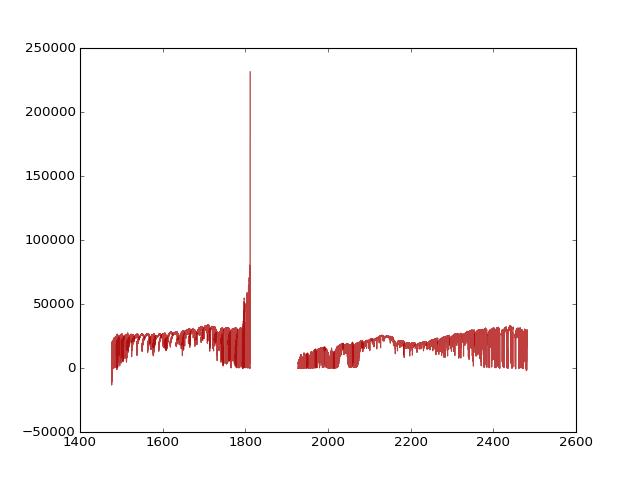

In [62]:

import DataStructures
fname = '../20141015/Corrected_HIP_109056-0.fits'
hdulist = fits.open(fname)
model_orders = [DataStructures.xypoint(x=hdu.data['wavelength'], y=hdu.data['model']) for hdu in hdulist[1:]]
data_orders = [DataStructures.xypoint(x=hdu.data['wavelength'], y=hdu.data['flux'],
                                      cont=hdu.data['continuum'], err=hdu.data['error']) for hdu in hdulist[1:]]

# H band
model_orders_H = [o.copy() for o in model_orders if o.x[-1] < 1870]
data_orders_H = [o.copy() for o in data_orders if o.x[-1] < 1870]
ordernums_H = 121.0 - np.arange(len(model_orders_H))
p_H = fit_wavelength(model_orders_H, ordernums_H, first_order=3, last_order=len(ordernums_H) - 4)

# K band
model_orders_K = [o.copy() for o in model_orders if o.x[-1] > 1870]
data_orders_K = [o.copy() for o in data_orders if o.x[-1] > 1870]
ordernums_K = 92.0 - np.arange(len(model_orders_K))
p_K = fit_wavelength(model_orders_K, ordernums_K, first_order=7, last_order=len(ordernums_K) - 4)

new_orders = []
for i, order in enumerate(data_orders):
    pixels = np.arange(order.size(), dtype=np.float)
    if order.x[-1] < 1870:
        # H band
        ordernum = ordernums_H[i] * np.ones_like(pixels)
        wave = p_H(pixels, ordernum) / ordernum
    else:
        # K band
        ordernum = ordernums_K[i-len(ordernums_H)] * np.ones_like(pixels)
        wave = p_K(pixels, ordernum) / ordernum
        
    #ordernum = np.ones_like(pixels) * ap2ord(i)
    #wave = p(pixels, ordernum) / ordernum
    new_orders.append(DataStructures.xypoint(x=wave, y=order.y, cont=order.cont, err=order.err))

for original, corrected in zip(data_orders, new_orders):
    plt.plot(original.x, original.y, 'k-', alpha=0.5)
    plt.plot(corrected.x, corrected.y, 'r-', alpha=0.5)

    

In [56]:
import SpecFlattener

In [57]:
SpecFlattener.flatten_spec?

In [47]:
header = fits.getheader('../20141015/HIP_109056.fits')
print(header.cards)

('SIMPLE', True, 'conforms to FITS standard')
('BITPIX', 8, 'array data type')
('NAXIS', 0, 'number of array dimensions')
('EXTEND', True, '')
('OBJECT', 'HIP 109056', '')
('RA', '+22:06:22.853750', '')
('DEC', '+29:02:4.575000', '')
('JD', 2456946.6215639, '')
('DATE-OBS', '2014-10-16T02:55:03.121', '')
('UT', '02:55:03.121', '')
('HUMIDITY', 30.08125, '')
('AIRTEMP', 61.34699999999999, '')
('BARPRESS', 23.58375, '')
('ZD', 6.570937589961102, '')
('NODFILE1', '20141015/SDCH_20141015_0086.fits', '')
('NODFILE2', '20141015/SDCH_20141015_0087.fits', '')
('NODFILE3', '20141015/SDCH_20141015_0088.fits', '')
('NODFILE4', '20141015/SDCH_20141015_0089.fits', '')
('NODFILE5', '20141015/SDCH_20141015_0090.fits', '')
('NODFILE6', '20141015/SDCH_20141015_0091.fits', '')
('NODFILE7', '20141015/SDCH_20141015_0092.fits', '')
('NODFILE8', '20141015/SDCH_20141015_0093.fits', '')
('EXPTIME', 224.0, 'Total exposure time (seconds)')
